In [3]:
import math 
from math import floor, exp, sqrt, pi
import cmath 
import numpy 
import matplotlib.pyplot as plt
from numpy import e, cos, zeros, arange, roll, where, random, ones, mean, reshape, dot, array, flipud, pi, exp, dot, angle, degrees, shape, linspace

import scipy
from scipy import special
import numpy as np 
import time
import scipy.signal
from numpy.fft import rfft, irfft
import os
import sys
import socket
import multiprocessing as mp

from scipy.interpolate import interp1d

In [4]:
#prefs.codegen.target = 'cython'

start_time = time.time()
par = int()

In [5]:
############### Accesory functions
###############


def decode_rE(rE, N=512):
    #Population vector for a given rE
    # return ( angle in radians, absolut angle in radians, abs angle in degrees )
    N=len(rE)
    angles= np.arange(0,2*pi,2*np.pi/N) 
    R = np.sum(np.dot(np.reshape(rE, (1,N)),np.exp(1j*angles)))/np.sum(rE) ## population vector 
    angle_decoded = np.degrees(np.angle(R))
    strength_code = np.abs(R)
    if angle_decoded<0:
        angle_decoded = 360+angle_decoded 
    
    return angle_decoded, strength_code


def model_I0E_constant(value, N=512): 
    y=[value for x in range(N)] 
    return np.reshape(np.array(y), (N,1)) 



In [6]:
############### MODEL STPA function
###############


def model_STPA(totalTime, targ_onset1, presentation_period, delay1,iti,angle_pos= random.random()*360, RV=1, 
    tauE=60, tauI=10, tauf=7000, taud=80, I0E=0.6, I0I=0.4, U=0.4, Gad=0.001, gadapt=0.5, tauad=1500,
    GEE=0.016, GEI=0.015, GIE=0.012 , GII=0.007, sigE=0.06, sigI=0.04,
    kappa_E=100, kappa_I=1.5, k_inhib=0.07, kappa_stim=20,
    N=512, save_RE=True):
    ##

    # Task timings converted to simulation steps
    st_sim =time.time()
    dt=2;
    nsteps=int(floor(totalTime/dt)); 
    origin = np.radians(angle_pos) 
    targ_offset1 = targ_onset1 + presentation_period; 
    targon1 = floor(targ_onset1/dt);
    targoff1 = floor(targ_offset1/dt); 
    resp_onset = targ_offset1 + delay1 ; 
    resp_offset = resp_onset + presentation_period;
    respon = floor (resp_onset/dt);
    respoff = floor( resp_offset/dt);
    ######

    ###### Definition of the network connectivity WE and WI
    v_E=np.zeros((N)); 
    v_I=np.zeros((N));
    WE=np.zeros((N,N));
    WI=np.zeros((N,N));
    theta =np.arange(0,2*pi,2*pi/N) 

    v_E_new=[e**(kappa_E*np.cos(theta[f]))/(2*pi*scipy.special.i0(kappa_E)) for f in range(0, len(theta))]  # use a translationally invariant von Mises function to define the ring connectivity
    v_I_new=[e**(kappa_I*np.cos(theta[f]))/(2*pi*scipy.special.i0(kappa_I)) + k_inhib for f in range(0, len(theta))] 
    for i in range(0, N):
        #    
        vE_NEW=np.roll(v_E_new,i) 
        vI_NEW=np.roll(v_I_new,i) 
        # 
        WE[:,i]=vE_NEW 
        WI[:,i]=vI_NEW

    ###### Definition of the current corresponding to stimulus 1: target 
    target=np.zeros((N)) 
    for i in range(0, N):
        target[i]=RV*(e**(kappa_stim*cos(theta[i] - origin ))  / (2*pi*scipy.special.i0(kappa_stim)))
    #
    noise_stim = np.random.normal(0, 0.01, N) 
    target = target+ noise_stim
    target=reshape(target, (N,1)) 
     
    #
    ###### Initialize all the variables for the simulation
    mf=1
    rE=np.zeros((N,1));
    rI=np.zeros((N,1)); 
    s1 = np.zeros((N,1));
    u = np.ones((N,1))*U
    x = np.ones((N,1))
    a = np.ones((N,1))*0.002 #a = np.zeros((N,1))
    RE=np.zeros((N,nsteps));
    RI=np.zeros((N,nsteps));
    SE=np.zeros((N,nsteps));
    AD=np.zeros((N,nsteps));
    p_u=np.ones((N,nsteps));
    p_x=np.ones((N,nsteps));
    
    ###
    ###
    ### input-output function converting currents into firing rates, to be used during the simulation
    fnc = lambda x : x*x*(x>0)*(x<1) + array([cmath.sqrt(4*x[i]-3) for i in range(0, len(x))]).real * (x>=1)
    xx=np.linspace(-5,10,100)
    yy=fnc(xx)
    func = interp1d(xx,yy, fill_value='extrapolate') # convert function into interpolated lookup table to make simulations much faster


        ### MAIN SIMULATION LOOP 
        # for each time step
    for i in range(0, nsteps):
        # independent noise to each neuron at each time step
        noiseE = sigE*random.randn(N,1);  
        noiseI = sigI*random.randn(N,1);
    
        # calculate the current inputs to each neuron based on the firing rates and the connectivity
        IE= GEE*dot(WE, (rE*u*x)) - GIE*dot(WI,rI) - Gad * a + I0E; 
        II= GEI*dot(WE,rE) +  (I0I-GII*mean(rI))*ones((N,1)); 
        
        ## consider additional inputs based on the task period: stimuli, response
        ## presentation stim 1
        if i>targon1 and i<targoff1:
            IE=IE+target;
            II=II+target;
        ## response 
        if i>respon and i<respoff: 
            IE = IE - 5 # hyperpolarize all neurons to stop the bumps
            II = II - 5 

    
        
        # Euler method applied to the differential rate equations, for each population
        rE = rE + (func(IE) - rE + noiseE)*dt/tauE;
        rI = rI + (func(II) - rI + noiseI)*dt/tauI;

        # Euler method applied to the differential equations of synaptic plasticity: paper mongillo, barak, tsodyks. Science 2008
        u = u + ((U - u) / tauf + U*(1-u)*rE/1000)*dt;
        x = x + ((1 - x)/taud - u*x*rE/1000)*dt;

        # Euler method applied to the differential equation of the adaptation current a
        a = a + (-a/tauad + gadapt * rE/1000) * dt

        ur=np.reshape(u, N)
        xr=np.reshape(x, N)

        #append results to arrays 
        RE[:,i] = np.reshape(rE, N);
        RI[:,i] = np.reshape(rI, N);
        p_u[:,i] = ur;
        p_x[:,i] = xr;
        SE[:,i]= ur*xr;
        AD[:,i] = np.reshape(a,N)





    #
    #### Decode positions
    final_position_bump, final_strength = decode_rE(RE[:,-5], N)
    previous_position_bump, previous_strength =decode_rE(RE[:,respon-1], N) 


    #p_targ = int((N * np.degrees(origin))/360) 

     
    ### Output
    ###return bias_target, bias_dist, number_of_bumps, angle_separation, RE #rE[p_targ][0], I0E
    if save_RE==True:
        return RE, WE , SE, AD
    else:
        return RE, WE , SE, AD

In [7]:
    #####
    ##### Codes to run simulations
    #####
    Angle_pres1 = 120 #degrees 
    target_onset1 = 1500 #ms
    presentation_period = 250 #ms
    target_offset1 = target_onset1 + presentation_period 
    delay1= np.random.choice([1,2])*1000  #1500
    resp_onset = target_offset1 + delay1 
    resp_offset = resp_onset + presentation_period 
    iti = np.random.choice([1,2])*1000 #ms
    time_simulation=target_offset1 + delay1
    RV=1
    saveRE = True

In [8]:
    results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=Angle_pres1,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=512,save_RE=saveRE)

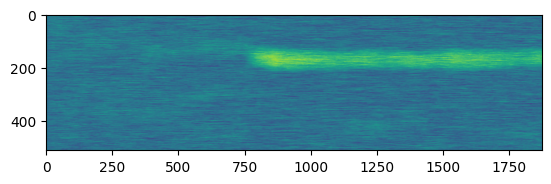

<Figure size 640x480 with 0 Axes>

In [9]:
    if saveRE==True:
        RE = results[0]
        plt.figure()
        plt.imshow(RE)

        plt.figure()
        
        plt.show()

## 1. Check the effect of varying Intensity 

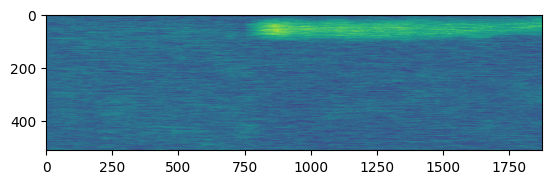

<Figure size 640x480 with 0 Axes>

In [10]:
angle_pos=40
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=512,save_RE=saveRE)

if saveRE==True:
    RE = results[0]
    plt.figure()
    plt.imshow(RE)

    plt.figure()
        
    plt.show()
    

##plotting rate 

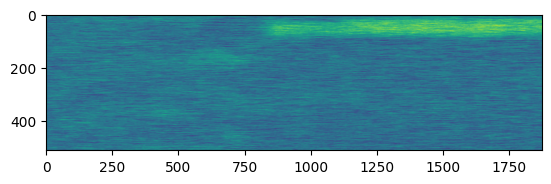

<Figure size 640x480 with 0 Axes>

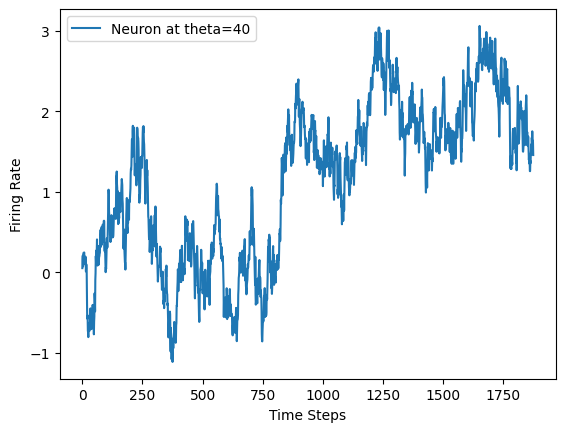

In [11]:
angle_pos=40
N=512
RV=0.5
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    A = results[0]
    plt.figure()
    plt.imshow(A)

    plt.figure()
        
    plt.show()
    
angle_pos_index = int( angle_pos/(360 / N)) % N
plt.plot(A[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()   




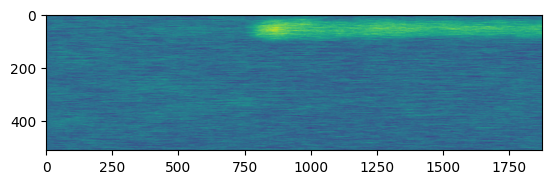

<Figure size 640x480 with 0 Axes>

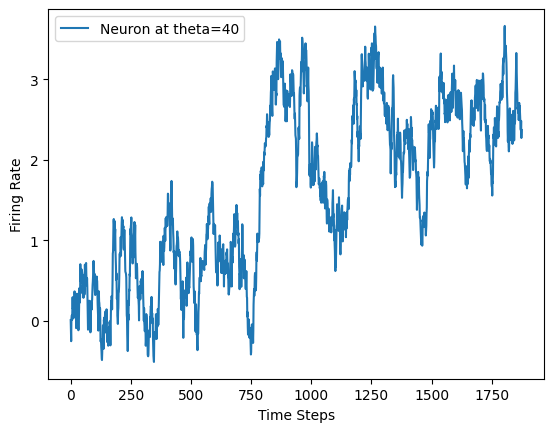

In [12]:
angle_pos=40
N=512
RV=1
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    B = results[0]
    plt.figure()
    plt.imshow(B)

    plt.figure()
        
    plt.show()
angle_pos_index = int( angle_pos/(360 / N)) % N
plt.plot(B[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()   



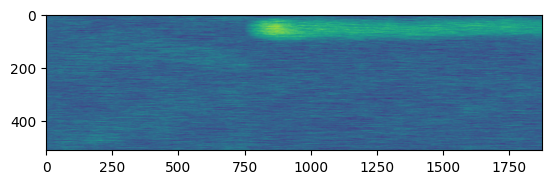

<Figure size 640x480 with 0 Axes>

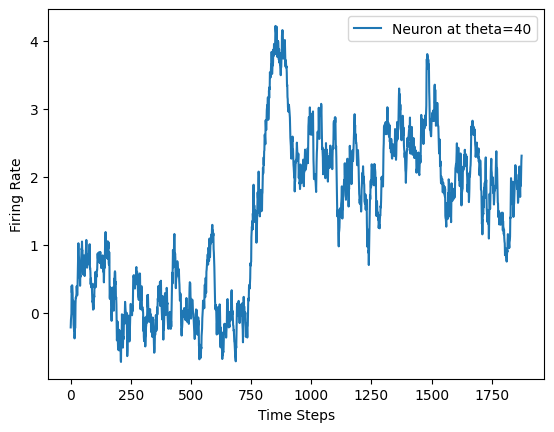

In [13]:
angle_pos=40
N=512
RV=1.5
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    C = results[0]
    plt.figure()
    plt.imshow(C)

    plt.figure()
        
    plt.show()
angle_pos_index = int( angle_pos/(360 / N)) % N
plt.plot(C[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()

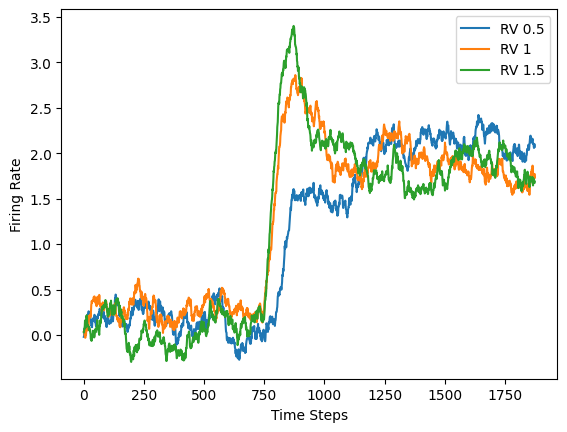

In [14]:
pick=np.arange(angle_pos-10,angle_pos+10)
plt.plot(np.mean(A[pick, :], axis=0),label=f'RV 0.5')
plt.plot(np.mean(B[pick, :], axis=0),label=f'RV 1')
plt.plot(np.mean(C[pick, :], axis=0),label=f'RV 1.5')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()   

## Effect of changing Gee

GEE= up by 10 percent

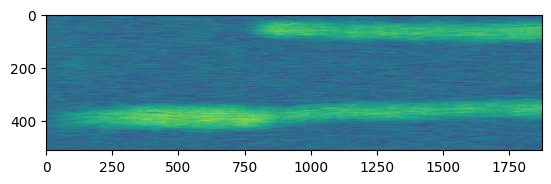

<Figure size 640x480 with 0 Axes>

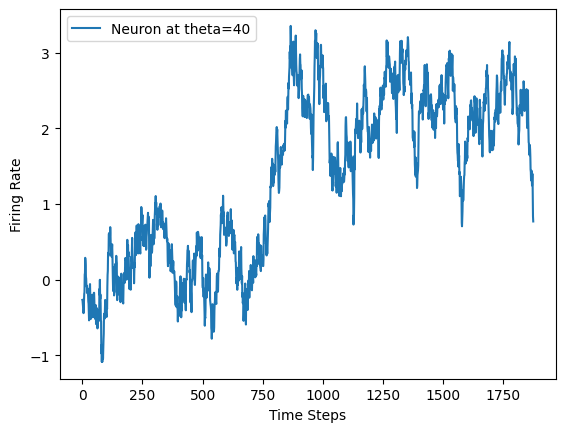

In [15]:
angle_pos=40
N=512
RV=1
GEE=0.02585
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=GEE, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    GEEup = results[0]
    plt.figure()
    plt.imshow(GEEup)
    plt.figure()
        
    plt.show()

angle_pos_index = int( angle_pos/(360 / N)) % N

plt.plot(GEEup[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()  

GEE up by 10 percent, RV = 0

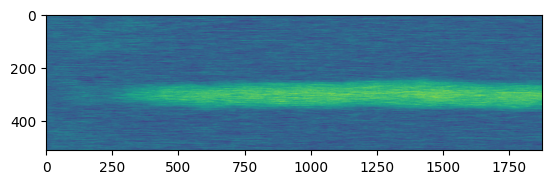

<Figure size 640x480 with 0 Axes>

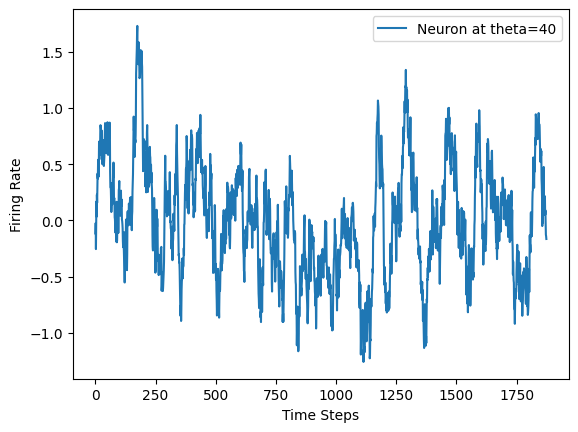

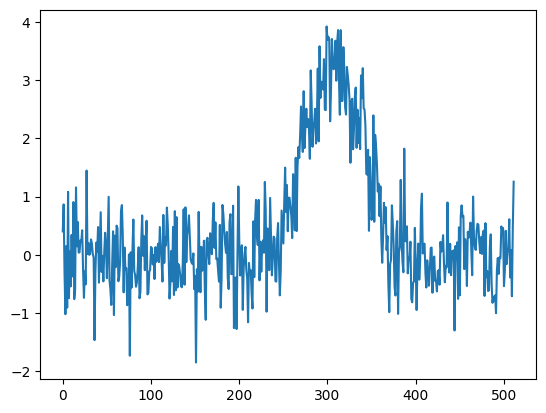

In [16]:
angle_pos=40
N=512
RV=0
GEE=0.02585
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=GEE, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    GEErv0 = results[0]
    plt.figure()
    plt.imshow(GEErv0)

    plt.figure()
        
    plt.show()
    
angle_pos_index = int( angle_pos/(360 / N)) % N

plt.plot(GEErv0[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()


plt.figure()
plt.plot(GEErv0[:,-1])

plt.show()  

GEE down by 10 percent

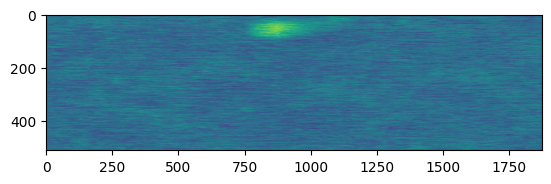

<Figure size 640x480 with 0 Axes>

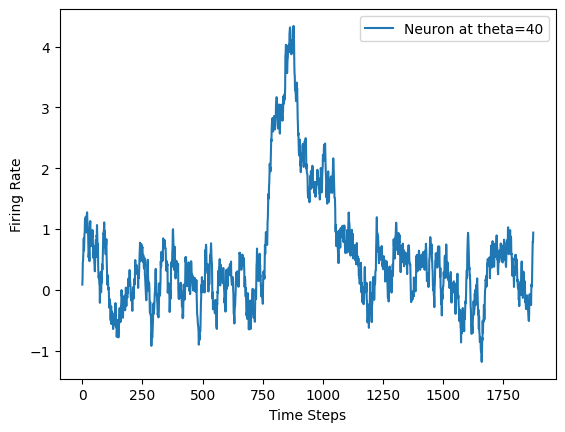

In [17]:
angle_pos=40
N=512
RV=1
GEE=0.02115
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=GEE, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    GEEdown = results[0]
    plt.figure()
    plt.imshow(GEEdown)

    plt.figure()
        
    plt.show()
    
angle_pos_index = int( angle_pos/(360 / N)) % N
plt.plot(GEEdown[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()   

GEE down , RV =0

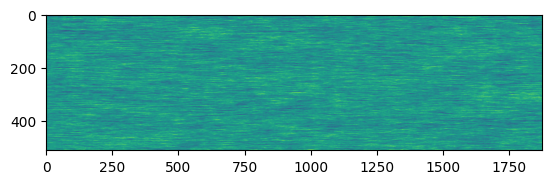

<Figure size 640x480 with 0 Axes>

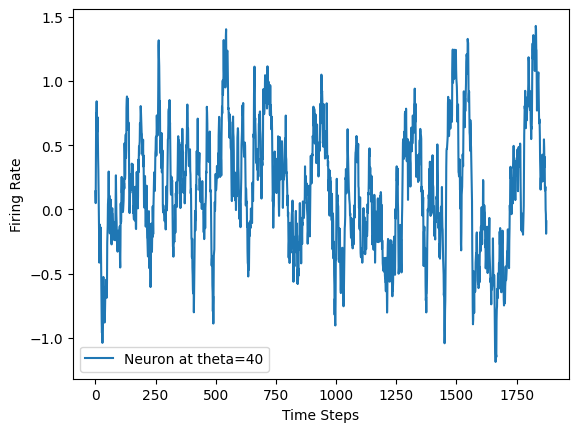

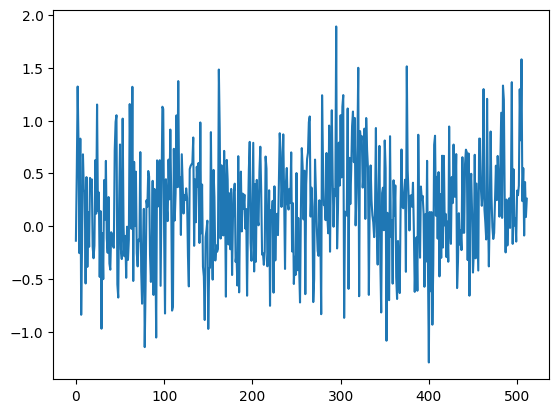

In [18]:
angle_pos=40
N=512
RV=0
GEE=0.02115
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=GEE, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    GEEdownrv0 = results[0]
    plt.figure()
    plt.imshow(GEEdownrv0)

    plt.figure()
        
    plt.show()
    
angle_pos_index = int( angle_pos/(360 / N)) % N
plt.plot(GEEdownrv0[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()

plt.figure()
plt.plot(GEEdownrv0[:,-1])
plt.show()   

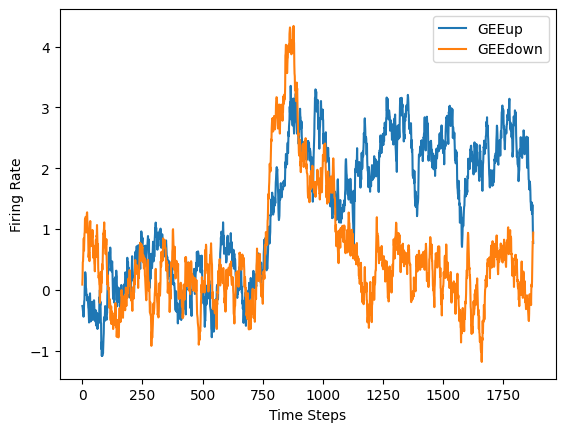

In [19]:
plt.plot(GEEup[angle_pos_index, :],label=f'GEEup')
plt.plot(GEEdown[angle_pos_index, :],label=f'GEEdown')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()   

GIE up by 10 percent

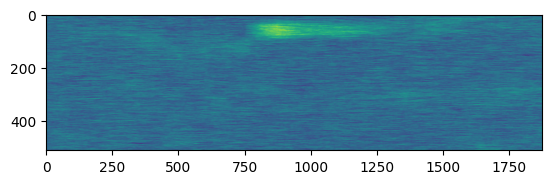

<Figure size 640x480 with 0 Axes>

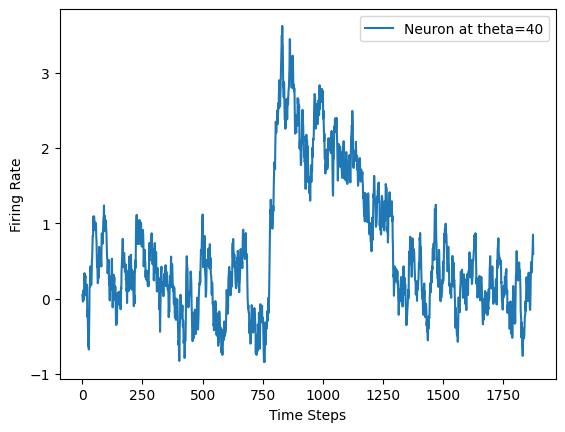

In [20]:
angle_pos=40
N=512
RV=1
GIE=0.011
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=GIE, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    GIEup = results[0]
    plt.figure()
    plt.imshow(GIEup)

    plt.figure()
        
    plt.show()
    
angle_pos_index = int( angle_pos/(360 / N)) % N
plt.plot(GIEup[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()

GIE up by 10, RV =0

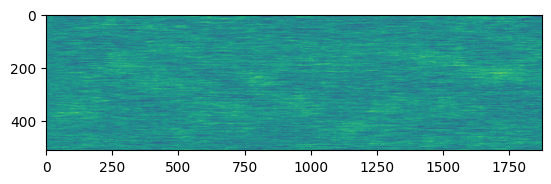

<Figure size 640x480 with 0 Axes>

In [21]:
angle_pos=40
N=512
RV=0
GIE=0.011
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=GIE, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    GIErv0 = results[0]
    plt.figure()
    plt.imshow(GIErv0)

    plt.figure()
        
    plt.show()
    


GIEdown by 10 

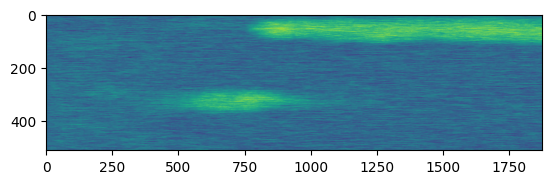

<Figure size 640x480 with 0 Axes>

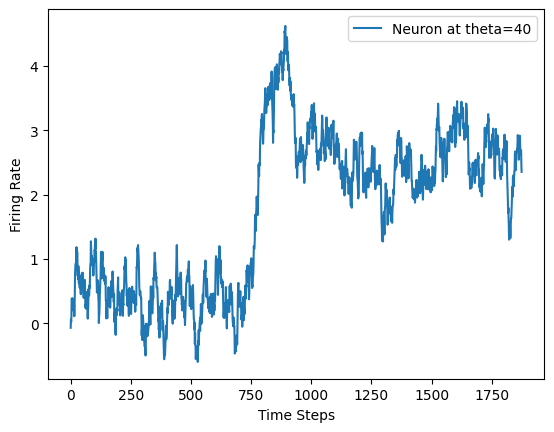

In [22]:
angle_pos=40
N=512
RV=1
GIE=0.009
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=GIE, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    GIEdown = results[0]
    plt.figure()
    plt.imshow(GIEdown)

    plt.figure()
        
    plt.show()
    
angle_pos_index = int( angle_pos/(360 / N)) % N
plt.plot(GIEdown[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()

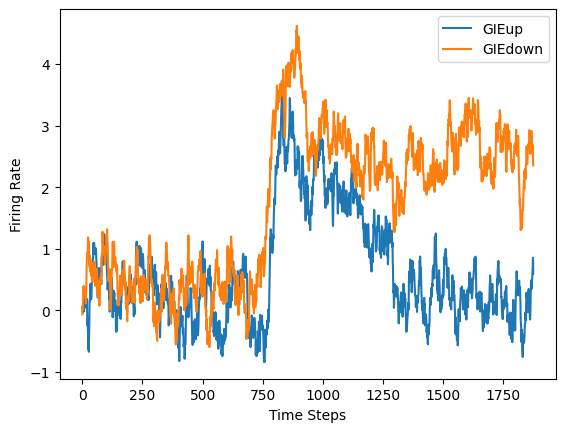

In [23]:
plt.plot(GIEup[angle_pos_index, :],label=f'GIEup')
plt.plot(GIEdown[angle_pos_index, :],label=f'GIEdown')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()  

Finding the window of bistability 

reference code

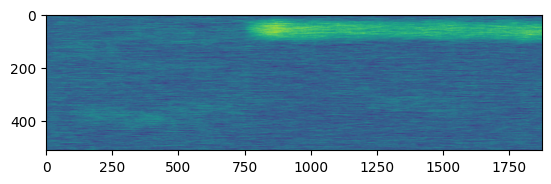

<Figure size 640x480 with 0 Axes>

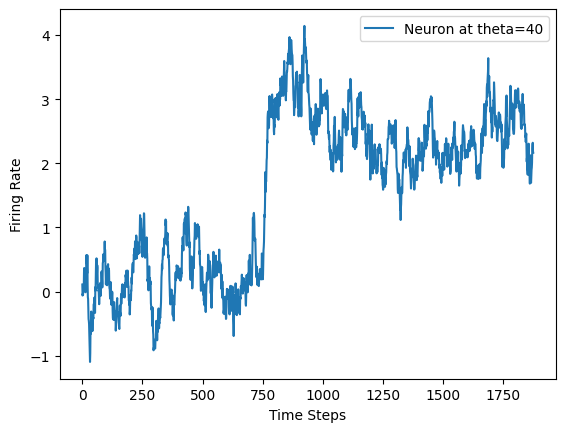

In [24]:
angle_pos=40
N=512
RV=1
results= model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
            targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
            tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
            I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
            GEE=0.0235, GEI=0.019, GIE=0.01, GII=0.1,
            sigE=4, sigI=2.2,
            kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
            N=N,save_RE=saveRE)
if saveRE==True:
    B = results[0]
    plt.figure()
    plt.imshow(B)

    plt.figure()
        
    plt.show()
angle_pos_index = int( angle_pos/(360 / N)) % N
plt.plot(B[angle_pos_index, :],label=f'Neuron at theta={angle_pos}')
        #plt.plot(RE[opposite_angle_index, :],label=f'Neuron at theta={opposite_angle}')
plt.xlabel('Time Steps')
plt.ylabel('Firing Rate')
plt.legend()
plt.show()   


In [79]:


def multiple_trials(number_of_trials):
    GEEs = np.arange(0.01175, 0.0352, 0.000235)
    results = []
    for GEE in GEEs :
        angle_pos=40
        N=512
        RV=1
        save_RE= True
        model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
                    targ_onset1= target_onset1, angle_pos=angle_pos,RV=RV, delay1=delay1, iti=iti ,
                    tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
                    I0I=0.4, U=0.9,  Gad=1, gadapt =0.01, tauad=1500,
                    GEE=0.0235, GEI=0.019, GIE=0.01, GII=0.1,
                    sigE=4, sigI=2.2,
                    kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
                    N=N,save_RE=saveRE)
        
        
        results.append(RE[:,-1])  # Append the final column of the result to the list

    return np.array(results)









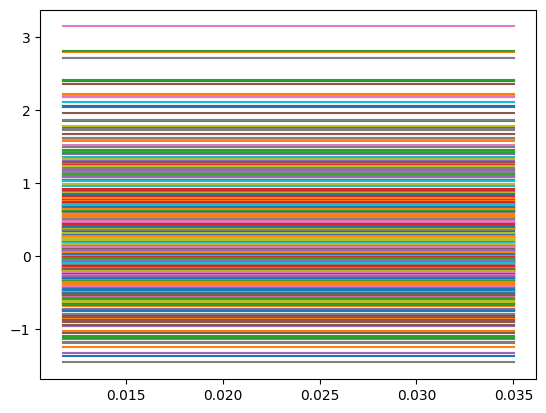

In [80]:
number_of_trials=1
results = multiple_trials(number_of_trials=number_of_trials)
GEEs = np.arange(0.01175, 0.0352, 0.000235)

plt.figure()
plt.plot(GEEs, results)
plt.show()


In [112]:
def Ntrials(num_trials):
    angle_pos=300
    N = 512
    RV = 1
    save_RE= True
    for _ in range(num_trials):
        model_STPA(totalTime=time_simulation, presentation_period=presentation_period,   
                   targ_onset1=target_onset1, angle_pos=angle_pos, RV=RV, delay1=delay1, iti=iti,
                   tauE=60, tauI=10, tauf=2000, taud=80, I0E=0.6,
                   I0I=0.4, U=0.9, Gad=1, gadapt=0.01, tauad=1500,
                   GEE=0.01175, GEI=0.019, GIE=0.01, GII=0.1,
                   sigE=4, sigI=2.2,
                   kappa_E=12, kappa_I=1.5, k_inhib=0.07, kappa_stim=12,
                   N=N, save_RE=save_RE)


TypeError: Invalid shape (1875,) for image data

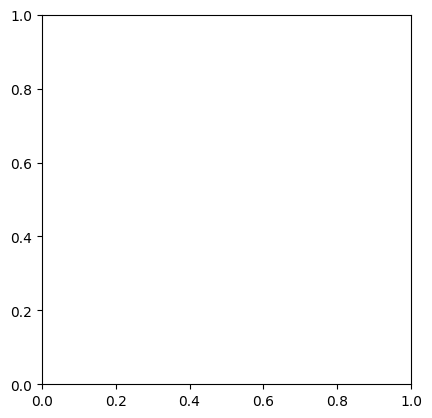

In [114]:
num_trials=1
results=Ntrials(num_trials=num_trials)
if saveRE==True:
    if saveRE==True:
    G = results[0]
    plt.figure()
    plt.imshow(G)

    plt.figure()
        
    plt.show()
    plt.figure()
    plt.imshow(G)

    plt.figure()
        
    plt.show()